In [ ]:
import pandas as pd
import numpy as np
import requests
import math
import re
import nltk
import joblib
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [ ]:
# This funcion will preprocess the reviews by doing the following:
# Lemmatizing
# Tokenizing
# Remving stopwords
# Removing non-alpha characters
def clean_reviews(reviews):
    lem = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(reviews)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopwords]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm = [lem.lemmatize(word) for word in no_alpha]
    clean = lemm
    return clean

In [ ]:
# This function will work as a sort of pipeline for vectorizing reviews and extracting features.
def vectorize(data, vec):
    rev_vec = vec.transform(data)
    rev_array = rev_vec.toarray()
    return rev_array

In [ ]:
# This function will process reviews to use with the keras tokenizer.
no_alpha = re.compile(r'[\W]')
no_ascii = re.compile(r'[^a-z0-1\s]')
def normalize_reviews(reviews):
    normalized_rev = []
    for text in reviews:
        lower = text.lower()
        no_punctuation = no_alpha.sub(r' ', lower)
        no_non_ascii = no_ascii.sub(r'', no_punctuation)
        normalized_rev.append(no_non_ascii)
    return normalized_rev

In [ ]:
def pad(token, length):
    if not length:
        length = max(len(text) for text in token)
    else:
        length = length
    
    tokens = pad_sequences(token, maxlen=length)
    return tokens

def cnn_pred(preds):
    pr = np.transpose(preds)[0]
    pr = list(map(lambda x: 0 if x < 0.5 else 1, pr))
    return pr

In [ ]:
def get_url():
    url = input('Product URL:')
    spl = url.split('/')
    id = spl[spl.index('dp') + 1]
    url = f'https://www.amazon.com/product-reviews/{id}/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&reviewerType=all_reviews&sortBy=recent&pageNumber='
    return url

def get_url():
    url = input('Product URL:')
    spl = url.split('/')
    id = spl[spl.index('dp') + 1]
    url = f'https://www.amazon.com/product-reviews/{id}/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&reviewerType=all_reviews&sortBy=recent&pageNumber='
    return url

def get_reviews(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0', 'Accept-Language': 'en-US, en;q=0.5'}
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    while True:
        try:
            rev_num = soup.find('div', class_='a-row a-spacing-base a-size-base').get_text().strip()
            break
        except:
            pass
    
    rev_num = int(rev_num.split(' ')[3].replace(',', ''))
    page_num = math.ceil(rev_num/10) + 1

    title = []
    reviews = []
    ratings = []
    date = []

    if rev_num > 1000:
        for page in np.arange(1,101):
            nurl = url + str(page)
            res = requests.get(nurl, headers=headers)
            soup = BeautifulSoup(res.text, 'html.parser')

            for item in soup.select('i[data-hook=review-star-rating]'):
                text = item.get_text()
                ratings.append(text)

            for item in soup.select('a[data-hook=review-title]'):
                text = item.get_text().replace('\n', '').strip()
                title.append(text)

            for item in soup.select('span[data-hook=review-body]'):
                text = item.get_text().replace('\n', '').strip()
                reviews.append(text)

            for item in soup.select('span[data-hook=review-date]'):
                text = item.get_text().strip().split(' ')[6:]
                text = ' '.join(text)
                date.append(text)

            if not soup.select('i[data-hook=review-star-rating]'):
                break
    else:
        for page in np.arange(1,page_num):
            nurl = url + str(page)
            res = requests.get(nurl, headers=headers)
            soup = BeautifulSoup(res.text, 'html.parser')

            for item in soup.select('i[data-hook=review-star-rating]'):
                text = item.get_text()
                ratings.append(text)

            for item in soup.select('a[data-hook=review-title]'):
                text = item.get_text().replace('\n', '').strip()
                title.append(text)

            for item in soup.select('span[data-hook=review-body]'):
                text = item.get_text().replace('\n', '').strip()
                reviews.append(text)
            
            for item in soup.select('span[data-hook=review-date]'):
                text = item.get_text().strip().split(' ')[6:]
                text = ' '.join(text)
                date.append(text)

            if not soup.select('i[data-hook=review-star-rating]'):
                break

    if len(title) != len(reviews):
        reviews = reviews[:len(title)]

    df = pd.DataFrame({'Title': title, 'Rev': reviews, 'Stars': ratings, 'Date': pd.to_datetime(date)})
    
    df['Reviews'] = df['Title'] + '. ' + df['Rev']
    df = df.drop(['Rev', 'Title'], axis=1)

    for c, r in enumerate(df['Stars']):
        df['Stars'].values[c] = df['Stars'].values[c][0]

    for c, col in enumerate(df['Reviews']):
        if 'The media could' in col:
            ind = col.index('The media could')
            df['Reviews'].values[c] = col[:ind] + col[ind+47:]
        else:
            pass
    
    return df

In [ ]:
# Scrape an amazon product page for reviews.
url = get_url()
amzn = get_reviews(url)

Product URL:https://www.amazon.com/Oral-B-iO-Electric-Toothbrush-Brush/dp/B088CK6XJ4/ref=cm_cr_arp_d_product_top?ie=UTF8


In [ ]:
# Load models and their dependencies
rf =  joblib.load('actual_best_rf.pkl')
vect = joblib.load('best_vectorizer.pkl')

cnn = load_model('best_CNN.h5')
with open('best_tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
# Preprocess amazon reviews and get predictions for the Random Forest Classifier.
rf_array = vectorize(amzn['Reviews'], vect)
rf_preds = rf.predict(rf_array)

In [ ]:
# Preprocess amazon reviews and get predictions for the Convolutional Neural Net.
norm_rev = normalize_reviews(amzn['Reviews'])
token = tokenizer.texts_to_sequences(norm_rev)
cnn_revs = pad(token, 241)

cnn_preds = cnn.predict(cnn_revs)
cnn_preds = cnn_pred(cnn_preds)

19/19 [==============================] - 0s 3ms/step


In [ ]:
# Append prediction back to original dataframe
amzn['RF_Predictions'] = rf_preds
amzn['CNN_Predictions'] = cnn_preds
amzn.head(10)

,Stars,Reviews,RF_Predictions,CNN_Predictions
0,5,Excellent IO series toothbrush!!. Love the loo...,1,1
1,2,"App is terrible. Toothbrush itself is good, bu...",0,0
2,1,Broken - Waste of Money. The toothbrush broke ...,0,0
3,1,"Poor quality, pricey with less than 6 month li...",0,0
4,5,Soft Brush. Great Service and Great Product!,1,1
5,2,After 2 weeks the battery went total dead. The...,0,0
6,5,I love my new toothbrush. My new toothbrush is...,1,1
7,5,Fabulous product!. Fabulous product. Keep on s...,1,1
8,1,Battery Goes Dead after 6 months and Won't Hol...,0,0
9,1,Magnetic charger doesn't work - unacceptable f...,1,1


In [ ]:
# Get a list of the positive and negative words from each review.
amzn['clean']=amzn['Reviews'].map(clean_reviews)
amzn['clean_text']=amzn['clean'].apply(lambda x: " ".join([str(word) for word in x]))

rf_pos = " ".join(amzn[amzn.RF_Predictions==1]['clean_text'].values)
rf_neg = " ".join(amzn[amzn.RF_Predictions==0]['clean_text'].values)

cnn_pos = " ".join(amzn[amzn.CNN_Predictions==1]['clean_text'].values)
cnn_neg = " ".join(amzn[amzn.CNN_Predictions==0]['clean_text'].values)

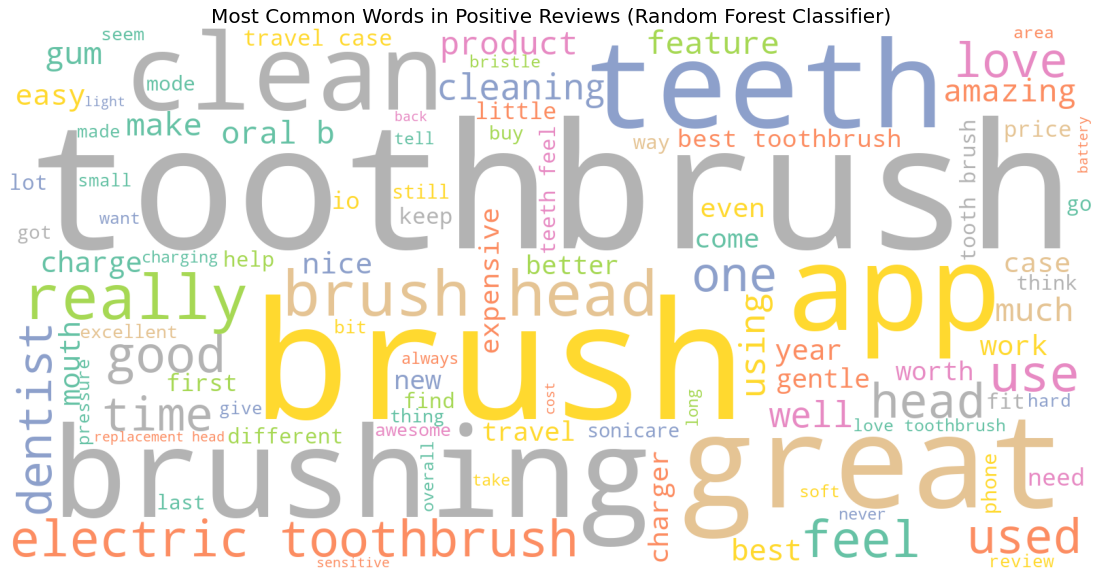

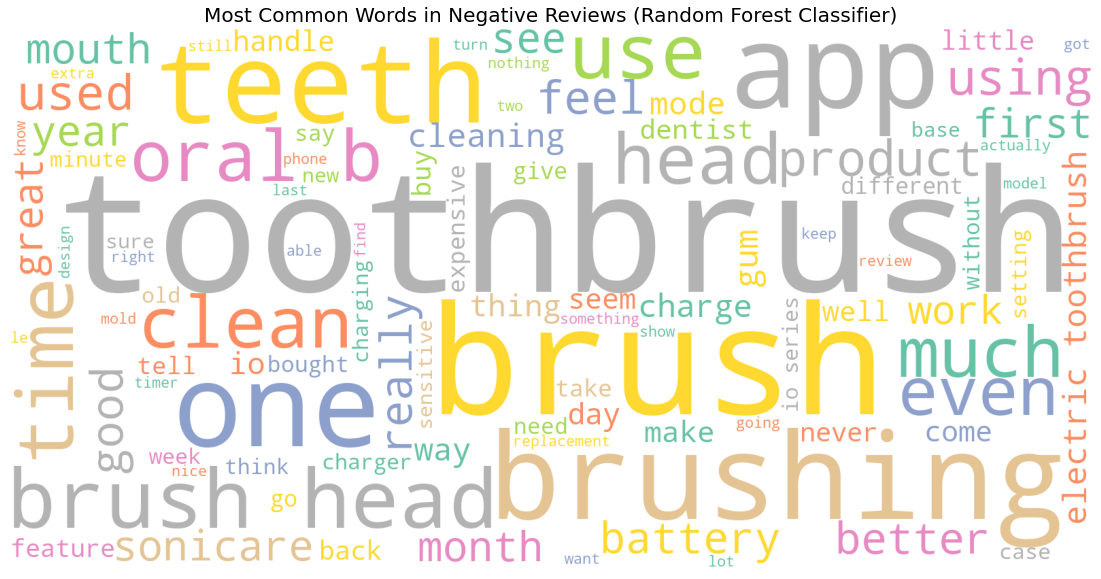

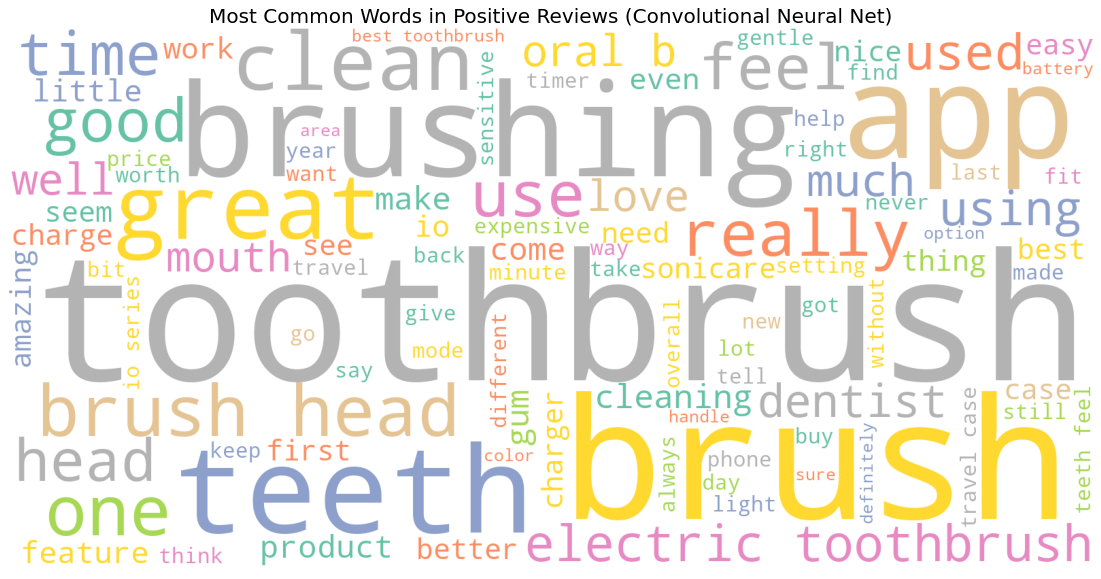

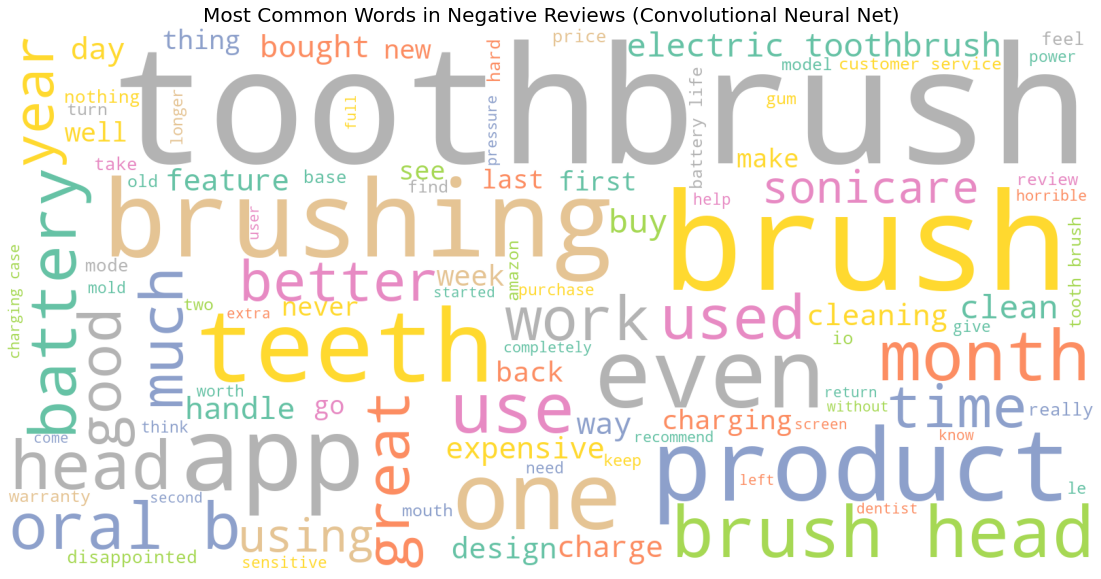

In [ ]:
# Make wordclouds based on the review sentiment.
def generate_wordcloud(words, sentiment, classifier):
    plt.figure(figsize=(20,10))
    wc = WordCloud(background_color="white", max_words=100, width=1600, height=800)
    wc.generate(words)
    words = wc.words_
    plt.title("Most Common Words in {} Reviews ({})".format(sentiment, classifier), fontsize=20)
    plt.imshow(wc.recolor(colormap='Set2', random_state=20))
    plt.axis('off')
    c = []
    
    for l in classifier.split(' '):
        c.append(l[0])
    c = ''.join(c)
    s = sentiment[:3].lower()
    
    wc.to_file('{}_{}.png'.format(c, s))
    return words

rf_poswords = generate_wordcloud(rf_pos, 'Positive', 'Random Forest Classifier')
rf_negwords = generate_wordcloud(rf_neg, 'Negative', 'Random Forest Classifier')

cnn_poswords = generate_wordcloud(cnn_pos, 'Positive', 'Convolutional Neural Net')
cnn_negwords = generate_wordcloud(cnn_neg, 'Negative', 'Convolutional Neural Net')

In [ ]:
# Create categorical classes for predictions.
amzn['RF_cat'] = amzn['RF_Predictions']
amzn['CNN_cat'] = amzn['CNN_Predictions']

amzn['RF_cat'] = amzn['RF_cat'].replace(0, 'Negative')
amzn['RF_cat'] = amzn['RF_cat'].replace(1, 'Positive')
amzn['CNN_cat'] = amzn['CNN_cat'].replace(0, 'Negative')
amzn['CNN_cat'] = amzn['CNN_cat'].replace(1, 'Positive')

Text(0.5, 1.0, 'Convolutional Neural Net')

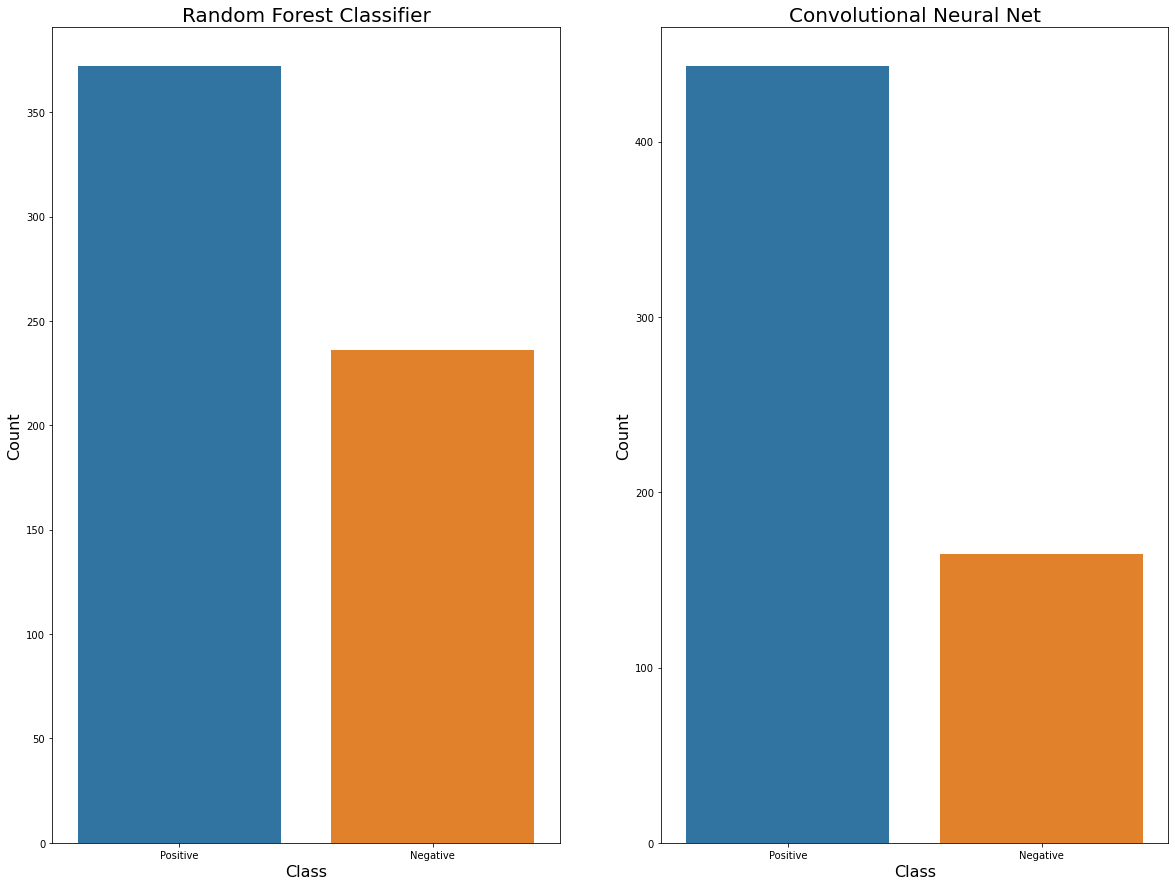

In [ ]:
# Plot and compare classification of reviews between the two models.
plt.figure(figsize=(20,15))

plt.subplot(1,2,1)
sns.countplot(x = amzn['RF_cat'])

plt.ylabel('Count', fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.title('Random Forest Classifier', fontsize=20)

plt.subplot(1,2,2)
sns.countplot(x = amzn['CNN_cat'])

plt.ylabel('Count', fontsize=16)
plt.xlabel('Class', fontsize=16)
plt.title('Convolutional Neural Net', fontsize=20)

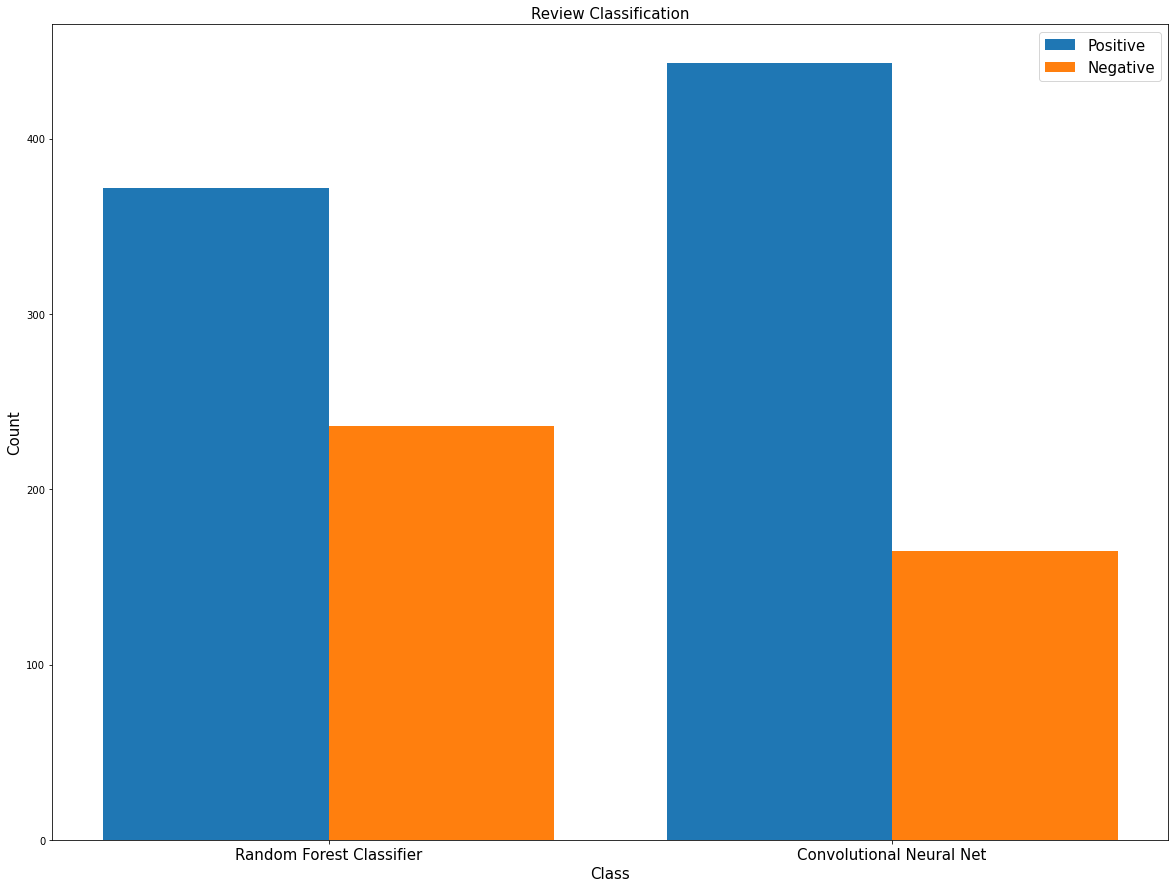

In [ ]:
# Plot and compare classification of reviews between the two models.
plt.figure(figsize=(20,15))
X = ['Random Forest Classifier','Convolutional Neural Net']
r = []
c = []

r.append(len([i for i in amzn['RF_Predictions'] if i == 1]))
c.append(len([i for i in amzn['RF_Predictions'] if i == 0]))
r.append(len([i for i in amzn['CNN_Predictions'] if i == 1]))        
c.append(len([i for i in amzn['CNN_Predictions'] if i == 0]))

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, r, 0.4, label = 'Positive')
plt.bar(X_axis + 0.2, c, 0.4, label = 'Negative')


plt.xticks(X_axis, X, fontsize=15)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Review Classification", fontsize=15)
plt.legend(prop={'size': 15})
plt.show()